In [2]:
from __future__ import absolute_import, division, print_function
from sklearn.model_selection import train_test_split
from math import sqrt
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
import os
import time

Using TensorFlow backend.


## Data Processing

In [65]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())
datapath = '/home/ubuntu/data/JAMSTEC2/'
filenames = os.listdir(datapath)
data = []
count = 0.0
for filename in filenames:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()

In [66]:
%%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

CPU times: user 15.3 s, sys: 1.47 s, total: 16.8 s
Wall time: 16.7 s


## Building Model

In [67]:
%%time

# Hyper-parameters
epochs = 20         # This should be adjusted
batch_size = 64    # The larger the faster
learning_rate = 0.001


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


In [68]:
class Model_FC:    
    def forward(inputs):
        x = keras.layers.Dense(128, activation=tf.nn.relu)(inputs)
        x = keras.layers.Dense(64, activation=tf.nn.relu)(x)
        x = keras.layers.Dense(32, activation=tf.nn.relu)(x)
        x = keras.layers.Dense(16, activation=tf.nn.relu)(x)
        x = keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)
        return x
    
    def build():
        inputs = keras.layers.Input(shape=(X_train.shape[1],))
        outputs = Model_FC.forward(inputs)
        model = keras.Model(inputs=inputs, outputs=outputs)
        return model

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 15,105
Trainable params: 15,105
Non-trainable params: 0
_______________________________________________________

## Training

In [69]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterJAMSTEC2.hdf5', verbose=0, save_best_only=True)
#model.load_weights('weightsAfterJAMSTEC2.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])

Train on 2667864 samples, validate on 666967 samples
Epoch 1/20
2667864/2667864 [==============================] - 74s 28us/step - loss: 0.0519 - precision: 0.8574 - recall: 0.6350 - val_loss: 0.0489 - val_precision: 0.9200 - val_recall: 0.7965
Epoch 2/20
2667864/2667864 [==============================] - 69s 26us/step - loss: 0.0314 - precision: 0.9201 - recall: 0.8281 - val_loss: 0.0284 - val_precision: 0.9288 - val_recall: 0.8461
Epoch 3/20
2667864/2667864 [==============================] - 70s 26us/step - loss: 0.0265 - precision: 0.9338 - recall: 0.8574 - val_loss: 0.0221 - val_precision: 0.9399 - val_recall: 0.8645
Epoch 4/20
2667864/2667864 [==============================] - 76s 28us/step - loss: 0.0231 - precision: 0.9439 - recall: 0.8701 - val_loss: 0.0197 - val_precision: 0.9476 - val_recall: 0.8752
Epoch 5/20
2667864/2667864 [==============================] - 77s 29us/step - loss: 0.0207 - precision: 0.9506 - recall: 0.8795 - val_loss: 0.0265 - val_precision: 0.9502 - val_re

In [70]:
checkpointer

## Evaluation

In [71]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.epoch, np.sqrt(np.array(history.history['loss'])),
           label='Train Loss')
    plt.plot(history.epoch, np.sqrt(np.array(history.history['val_loss'])),
           label = 'Val loss')
    plt.legend()

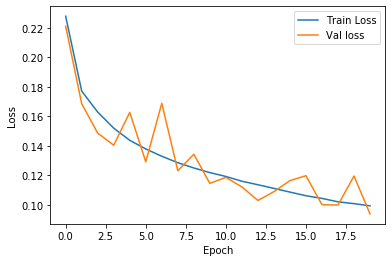

In [72]:
plot_history(history)

In [73]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.008
Validation Precision: 0.966
Validation Recall: 0.931


In [74]:
y_pred = model.predict(X_val)
# Compare this with y_val to get score

## NOW DO IT WITH FILES 0:100 OF THE JAMSTEC FOLDER

In [75]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())
datapath = '/home/ubuntu/data/JAMSTEC/'
filenames = os.listdir(datapath)
# filenames = ['JAMSTEC-part00000.tsv']
print(len(filenames))
data = []
count = 0.0
for filename in filenames[0:100]:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()

500


In [76]:
%%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

CPU times: user 21.3 s, sys: 1.64 s, total: 23 s
Wall time: 22.8 s


In [80]:
%%time

# Hyper-parameters
epochs = 10         # This should be adjusted
batch_size = 128    # The larger the faster
learning_rate = 0.001

class Model_FC:    
    def forward(inputs):
        x = keras.layers.Dense(128, activation=tf.nn.relu)(inputs)
        x = keras.layers.Dense(64, activation=tf.nn.relu)(x)
        x = keras.layers.Dense(32, activation=tf.nn.relu)(x)
        x = keras.layers.Dense(16, activation=tf.nn.relu)(x)
        x = keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)
        return x
    
    def build():
        inputs = keras.layers.Input(shape=(X_train.shape[1],))
        outputs = Model_FC.forward(inputs)
        model = keras.Model(inputs=inputs, outputs=outputs)
        return model

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 15,105
Trainable params: 15,105
Non-trainable params: 0
_______________________________________________________

In [81]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterJAMSTEC_v1.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterJAMSTEC2.hdf5')

In [82]:
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])

Train on 3706477 samples, validate on 926620 samples
Epoch 1/10
3706477/3706477 [==============================] - 54s 15us/step - loss: 0.0079 - precision_2: 0.6760 - recall_2: 0.3160 - val_loss: 0.0063 - val_precision_2: 0.7941 - val_recall_2: 0.3830
Epoch 2/10
3706477/3706477 [==============================] - 53s 14us/step - loss: 0.0058 - precision_2: 0.8087 - recall_2: 0.4042 - val_loss: 0.0053 - val_precision_2: 0.8233 - val_recall_2: 0.4201
Epoch 3/10
3706477/3706477 [==============================] - 54s 14us/step - loss: 0.0051 - precision_2: 0.8304 - recall_2: 0.4312 - val_loss: 0.0043 - val_precision_2: 0.8390 - val_recall_2: 0.4398
Epoch 4/10
3706477/3706477 [==============================] - 53s 14us/step - loss: 0.0047 - precision_2: 0.8459 - recall_2: 0.4464 - val_loss: 0.0042 - val_precision_2: 0.8500 - val_recall_2: 0.4549
Epoch 5/10
3706477/3706477 [==============================] - 54s 14us/step - loss: 0.0043 - precision_2: 0.8531 - recall_2: 0.4627 - val_loss: 0.0

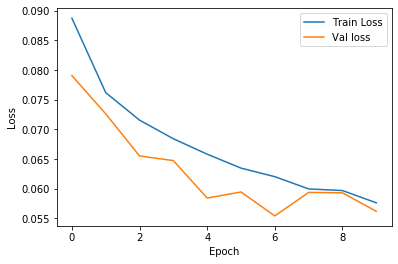

In [83]:
plot_history(history)

In [84]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.003
Validation Precision: 0.867
Validation Recall: 0.541


## now do it with 101-200 files of JAMSTEC

In [93]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/JAMSTEC/'
filenames = os.listdir(datapath)
# filenames = ['JAMSTEC-part00000.tsv']
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[101:200], 25)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    
## using 101-200 was too big for the np array so we subsampled by filename


500


In [94]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

In [95]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterJAMSTEC_v2.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterJAMSTEC_v1.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 908444 samples, validate on 227112 samples
Epoch 1/5
908444/908444 [==============================] - 8s 9us/step - loss: 0.0014 - precision_2: 0.8664 - recall_2: 0.5433 - val_loss: 9.8453e-04 - val_precision_2: 0.8656 - val_recall_2: 0.5430
Epoch 2/5
908444/908444 [==============================] - 8s 9us/step - loss: 8.5503e-04 - precision_2: 0.8652 - recall_2: 0.5428 - val_loss: 8.9670e-04 - val_precision_2: 0.8648 - val_recall_2: 0.5426
Epoch 3/5
908444/908444 [==============================] - 8s 9us/step - loss: 7.4808e-04 - precision_2: 0.8646 - recall_2: 0.5424 - val_loss: 6.9713e-04 - val_precision_2: 0.8643 - val_recall_2: 0.5424
Epoch 4/5
908444/908444 [==============================] - 8s 9us/step - loss: 7.6347e-04 - precision_2: 0.8639 - recall_2: 0.5424 - val_loss: 6.5841e-04 - val_precision_2: 0.8636 - val_recall_2: 0.5423
Epoch 5/5
908444/908444 [==============================] - 8s 9us/step - loss: 7.0877e-04 - precision_2: 0.8634 - recall_2: 0.5423 - val_los

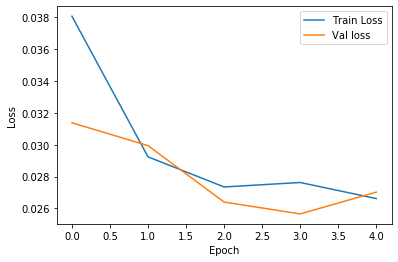

In [96]:
plot_history(history)

In [97]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.001
Validation Precision: 0.863
Validation Recall: 0.542


## now do it with JAMSTEC 201-300

In [98]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/JAMSTEC/'
filenames = os.listdir(datapath)
# filenames = ['JAMSTEC-part00000.tsv']
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[201:300], 25)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    
## using the all files in the 201-300 was too big for the np array so we subsampled by filename


500


In [99]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

In [100]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterJAMSTEC_v3.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterJAMSTEC_v2.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 918736 samples, validate on 229684 samples
Epoch 1/5
918736/918736 [==============================] - 8s 9us/step - loss: 0.0059 - precision_2: 0.8634 - recall_2: 0.5428 - val_loss: 0.0048 - val_precision_2: 0.8642 - val_recall_2: 0.5440
Epoch 2/5
918736/918736 [==============================] - 8s 9us/step - loss: 0.0045 - precision_2: 0.8648 - recall_2: 0.5459 - val_loss: 0.0043 - val_precision_2: 0.8654 - val_recall_2: 0.5480
Epoch 3/5
918736/918736 [==============================] - 8s 9us/step - loss: 0.0042 - precision_2: 0.8658 - recall_2: 0.5501 - val_loss: 0.0041 - val_precision_2: 0.8663 - val_recall_2: 0.5518
Epoch 4/5
918736/918736 [==============================] - 8s 9us/step - loss: 0.0039 - precision_2: 0.8671 - recall_2: 0.5538 - val_loss: 0.0041 - val_precision_2: 0.8678 - val_recall_2: 0.5556
Epoch 5/5
918736/918736 [==============================] - 8s 9us/step - loss: 0.0038 - precision_2: 0.8685 - recall_2: 0.5576 - val_loss: 0.0036 - val_precision_2: 0.8

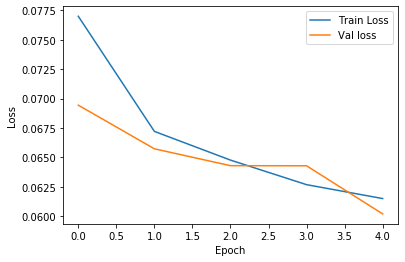

In [101]:
plot_history(history)

In [102]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.003
Validation Precision: 0.869
Validation Recall: 0.561


## now do it with JAMSTEC 301-400

In [103]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/JAMSTEC/'
filenames = os.listdir(datapath)
# filenames = ['JAMSTEC-part00000.tsv']
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[301:400], 25)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    
## using the all files in the 201-300 was too big for the np array so we subsampled by filename


500


In [104]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

In [105]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterJAMSTEC_v4.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterJAMSTEC_v3.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 946226 samples, validate on 236557 samples
Epoch 1/5
946226/946226 [==============================] - 9s 9us/step - loss: 0.0023 - precision_2: 0.8694 - recall_2: 0.5628 - val_loss: 0.0019 - val_precision_2: 0.8701 - val_recall_2: 0.5644
Epoch 2/5
946226/946226 [==============================] - 9s 9us/step - loss: 0.0019 - precision_2: 0.8709 - recall_2: 0.5660 - val_loss: 0.0016 - val_precision_2: 0.8716 - val_recall_2: 0.5676
Epoch 3/5
946226/946226 [==============================] - 9s 9us/step - loss: 0.0018 - precision_2: 0.8723 - recall_2: 0.5692 - val_loss: 0.0015 - val_precision_2: 0.8731 - val_recall_2: 0.5708
Epoch 4/5
946226/946226 [==============================] - 9s 9us/step - loss: 0.0017 - precision_2: 0.8738 - recall_2: 0.5725 - val_loss: 0.0017 - val_precision_2: 0.8745 - val_recall_2: 0.5742
Epoch 5/5
946226/946226 [==============================] - 9s 9us/step - loss: 0.0016 - precision_2: 0.8752 - recall_2: 0.5759 - val_loss: 0.0014 - val_precision_2: 0.8

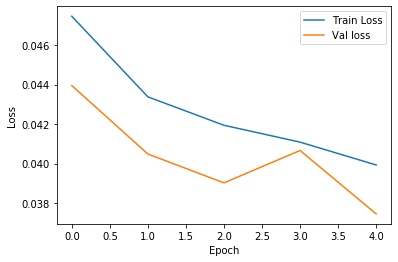

In [106]:
plot_history(history)

In [107]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.001
Validation Precision: 0.876
Validation Recall: 0.579


## now do it with JAMSTEC 401-500

In [108]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/JAMSTEC/'
filenames = os.listdir(datapath)
# filenames = ['JAMSTEC-part00000.tsv']
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[401:499], 25)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    
## using the all files in the 201-300 was too big for the np array so we subsampled by filename


500


In [109]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

In [110]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterJAMSTEC_v5.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterJAMSTEC_v4.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 1025536 samples, validate on 256384 samples
Epoch 1/5
1025536/1025536 [==============================] - 9s 9us/step - loss: 0.0098 - precision_2: 0.8818 - recall_2: 0.5954 - val_loss: 0.0069 - val_precision_2: 0.8886 - val_recall_2: 0.6147
Epoch 2/5
1025536/1025536 [==============================] - 9s 9us/step - loss: 0.0077 - precision_2: 0.8943 - recall_2: 0.6315 - val_loss: 0.0068 - val_precision_2: 0.8994 - val_recall_2: 0.6469
Epoch 3/5
1025536/1025536 [==============================] - 9s 9us/step - loss: 0.0069 - precision_2: 0.9040 - recall_2: 0.6606 - val_loss: 0.0058 - val_precision_2: 0.9081 - val_recall_2: 0.6734
Epoch 4/5
1025536/1025536 [==============================] - 9s 9us/step - loss: 0.0064 - precision_2: 0.9116 - recall_2: 0.6848 - val_loss: 0.0059 - val_precision_2: 0.9145 - val_recall_2: 0.6957
Epoch 5/5
1025536/1025536 [==============================] - 9s 9us/step - loss: 0.0063 - precision_2: 0.9172 - recall_2: 0.7053 - val_loss: 0.0053 - val_preci

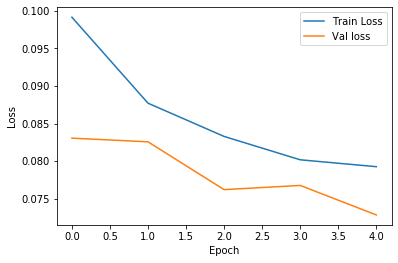

In [111]:
plot_history(history)

In [112]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.006
Validation Precision: 0.921
Validation Recall: 0.718


## OKAY, now onto the NGDC dataset files 0-100

In [158]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/NGDC/'
filenames = os.listdir(datapath)
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[0:100], 15)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    
## using the all files in the 201-300 was too big for the np array so we subsampled by filename


500


In [159]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [160]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterNGDC_v1.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterJAMSTEC_v5.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 656556 samples, validate on 164140 samples
Epoch 1/5
656556/656556 [==============================] - 7s 10us/step - loss: 0.0243 - precision_11: 0.6114 - recall_11: 0.3364 - val_loss: 0.0160 - val_precision_11: 0.7384 - val_recall_11: 0.4592
Epoch 2/5
656556/656556 [==============================] - 6s 9us/step - loss: 0.0155 - precision_11: 0.7616 - recall_11: 0.5084 - val_loss: 0.0133 - val_precision_11: 0.7800 - val_recall_11: 0.5469
Epoch 3/5
656556/656556 [==============================] - 6s 9us/step - loss: 0.0134 - precision_11: 0.7918 - recall_11: 0.5733 - val_loss: 0.0148 - val_precision_11: 0.8008 - val_recall_11: 0.5886
Epoch 4/5
656556/656556 [==============================] - 6s 9us/step - loss: 0.0120 - precision_11: 0.8069 - recall_11: 0.6013 - val_loss: 0.0106 - val_precision_11: 0.8123 - val_recall_11: 0.6185
Epoch 5/5
656556/656556 [==============================] - 6s 9us/step - loss: 0.0110 - precision_11: 0.8169 - recall_11: 0.6321 - val_loss: 0.0102 - v

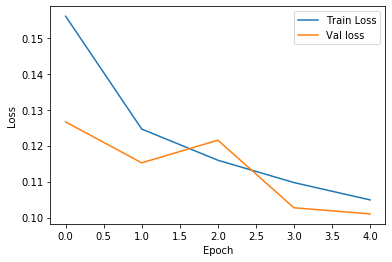

In [161]:
plot_history(history)

In [162]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.010
Validation Precision: 0.819
Validation Recall: 0.652


## now onto the NGDC dataset files 101-200

In [163]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/NGDC/'
filenames = os.listdir(datapath)
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[101:200], 15)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    
## using the all files in the 201-300 was too big for the np array so we subsampled by filename


500


In [164]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [165]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterNGDC_v2.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterNGDC_v1.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 694388 samples, validate on 173598 samples
Epoch 1/5
694388/694388 [==============================] - 7s 10us/step - loss: 0.0375 - precision_12: 0.8024 - recall_12: 0.5883 - val_loss: 0.0292 - val_precision_12: 0.8836 - val_recall_12: 0.6658
Epoch 2/5
694388/694388 [==============================] - 6s 9us/step - loss: 0.0256 - precision_12: 0.9009 - recall_12: 0.6907 - val_loss: 0.0241 - val_precision_12: 0.9100 - val_recall_12: 0.7116
Epoch 3/5
694388/694388 [==============================] - 6s 9us/step - loss: 0.0219 - precision_12: 0.9151 - recall_12: 0.7256 - val_loss: 0.0211 - val_precision_12: 0.9196 - val_recall_12: 0.7371
Epoch 4/5
694388/694388 [==============================] - 6s 9us/step - loss: 0.0199 - precision_12: 0.9225 - recall_12: 0.7463 - val_loss: 0.0203 - val_precision_12: 0.9247 - val_recall_12: 0.7545
Epoch 5/5
694388/694388 [==============================] - 6s 9us/step - loss: 0.0183 - precision_12: 0.9264 - recall_12: 0.7615 - val_loss: 0.0188 - v

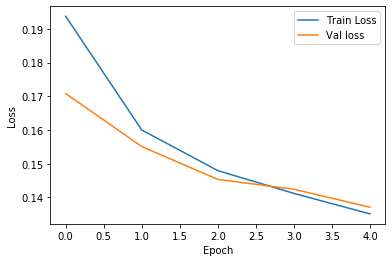

In [166]:
plot_history(history)

In [167]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.017
Validation Precision: 0.930
Validation Recall: 0.769


## now onto the NGDC dataset files 201-300

In [168]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/NGDC/'
filenames = os.listdir(datapath)
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[201:300], 15)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    
## using the all files in the 201-300 was too big for the np array so we subsampled by filename


500


In [169]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [170]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterNGDC_v3.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterNGDC_v2.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 708612 samples, validate on 177153 samples
Epoch 1/5
708612/708612 [==============================] - 7s 10us/step - loss: 0.0815 - precision_13: 0.8978 - recall_13: 0.7209 - val_loss: 0.0552 - val_precision_13: 0.9485 - val_recall_13: 0.8038
Epoch 2/5
708612/708612 [==============================] - 6s 9us/step - loss: 0.0454 - precision_13: 0.9567 - recall_13: 0.8254 - val_loss: 0.0412 - val_precision_13: 0.9605 - val_recall_13: 0.8431
Epoch 3/5
708612/708612 [==============================] - 6s 9us/step - loss: 0.0355 - precision_13: 0.9628 - recall_13: 0.8550 - val_loss: 0.0340 - val_precision_13: 0.9654 - val_recall_13: 0.8644
Epoch 4/5
708612/708612 [==============================] - 7s 9us/step - loss: 0.0306 - precision_13: 0.9672 - recall_13: 0.8715 - val_loss: 0.0292 - val_precision_13: 0.9680 - val_recall_13: 0.8788
Epoch 5/5
708612/708612 [==============================] - 7s 9us/step - loss: 0.0285 - precision_13: 0.9685 - recall_13: 0.8846 - val_loss: 0.0366 - v

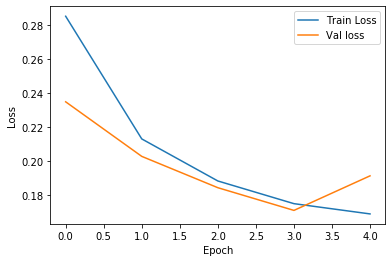

In [171]:
plot_history(history)

In [172]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.035
Validation Precision: 0.971
Validation Recall: 0.888


## now onto the NGDC dataset files 301-400

In [175]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/NGDC/'
filenames = os.listdir(datapath)
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[301:400], 12)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    
## using the all files in the 201-300 was too big for the np array so we subsampled by filename


500


In [176]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [177]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterNGDC_v4.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterNGDC_v3.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 425577 samples, validate on 106395 samples
Epoch 1/5
425577/425577 [==============================] - 5s 11us/step - loss: 0.0890 - precision_14: 0.7378 - recall_14: 0.5628 - val_loss: 0.0522 - val_precision_14: 0.8522 - val_recall_14: 0.6638
Epoch 2/5
425577/425577 [==============================] - 4s 9us/step - loss: 0.0461 - precision_14: 0.8734 - recall_14: 0.7091 - val_loss: 0.0391 - val_precision_14: 0.8886 - val_recall_14: 0.7423
Epoch 3/5
425577/425577 [==============================] - 4s 9us/step - loss: 0.0386 - precision_14: 0.8967 - recall_14: 0.7634 - val_loss: 0.0336 - val_precision_14: 0.9038 - val_recall_14: 0.7795
Epoch 4/5
425577/425577 [==============================] - 4s 9us/step - loss: 0.0350 - precision_14: 0.9083 - recall_14: 0.7911 - val_loss: 0.0361 - val_precision_14: 0.9122 - val_recall_14: 0.7996
Epoch 5/5
425577/425577 [==============================] - 4s 9us/step - loss: 0.0318 - precision_14: 0.9155 - recall_14: 0.8069 - val_loss: 0.0303 - v

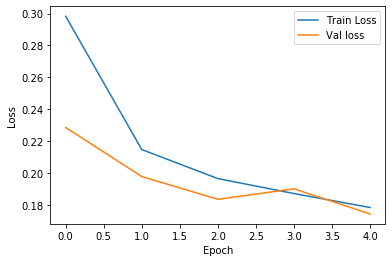

In [178]:
plot_history(history)

In [179]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.031
Validation Precision: 0.917
Validation Recall: 0.820


## now onto the NGDC dataset files 401-499

In [180]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/NGDC/'
filenames = os.listdir(datapath)
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[401:499], 15)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    
## using the all files in the 201-300 was too big for the np array so we subsampled by filename


500


In [181]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [182]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterNGDC_v5.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterNGDC_v4.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 725060 samples, validate on 181266 samples
Epoch 1/5
725060/725060 [==============================] - 7s 10us/step - loss: 0.0560 - precision_15: 0.7018 - recall_15: 0.4205 - val_loss: 0.0355 - val_precision_15: 0.7936 - val_recall_15: 0.5373
Epoch 2/5
725060/725060 [==============================] - 7s 9us/step - loss: 0.0332 - precision_15: 0.8082 - recall_15: 0.5833 - val_loss: 0.0280 - val_precision_15: 0.8212 - val_recall_15: 0.6164
Epoch 3/5
725060/725060 [==============================] - 7s 9us/step - loss: 0.0277 - precision_15: 0.8324 - recall_15: 0.6392 - val_loss: 0.0250 - val_precision_15: 0.8414 - val_recall_15: 0.6577
Epoch 4/5
725060/725060 [==============================] - 7s 9us/step - loss: 0.0243 - precision_15: 0.8488 - recall_15: 0.6716 - val_loss: 0.0213 - val_precision_15: 0.8545 - val_recall_15: 0.6870
Epoch 5/5
725060/725060 [==============================] - 7s 9us/step - loss: 0.0218 - precision_15: 0.8591 - recall_15: 0.7002 - val_loss: 0.0256 - v

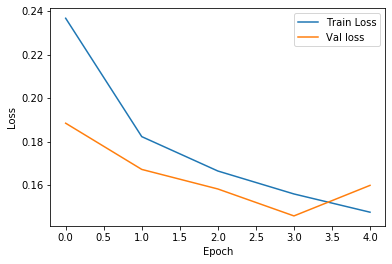

In [183]:
plot_history(history)

In [184]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.025
Validation Precision: 0.868
Validation Recall: 0.707


## OKAY, now onto the SIO data[0:100] ...

In [195]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/SIO/'
filenames = os.listdir(datapath)
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[0:100], 5)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    

500


In [196]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [197]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterSIO_v1.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterNGDC_v5.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 247150 samples, validate on 61788 samples
Epoch 1/5
247150/247150 [==============================] - 3s 12us/step - loss: 0.0197 - precision_16: 0.6107 - recall_16: 0.5983 - val_loss: 0.0095 - val_precision_16: 0.7509 - val_recall_16: 0.7696
Epoch 2/5
247150/247150 [==============================] - 2s 9us/step - loss: 0.0093 - precision_16: 0.7815 - recall_16: 0.8084 - val_loss: 0.0076 - val_precision_16: 0.8064 - val_recall_16: 0.8303
Epoch 3/5
247150/247150 [==============================] - 2s 9us/step - loss: 0.0076 - precision_16: 0.8220 - recall_16: 0.8428 - val_loss: 0.0070 - val_precision_16: 0.8354 - val_recall_16: 0.8495
Epoch 4/5
247150/247150 [==============================] - 2s 9us/step - loss: 0.0069 - precision_16: 0.8443 - recall_16: 0.8523 - val_loss: 0.0059 - val_precision_16: 0.8529 - val_recall_16: 0.8568
Epoch 5/5
247150/247150 [==============================] - 2s 9us/step - loss: 0.0061 - precision_16: 0.8600 - recall_16: 0.8602 - val_loss: 0.0117 - va

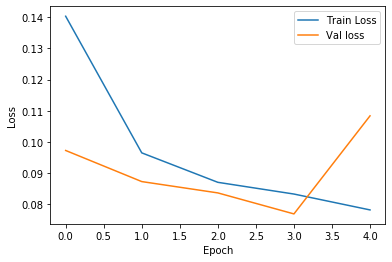

In [198]:
plot_history(history)

In [199]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.012
Validation Precision: 0.871
Validation Recall: 0.852


## SIO 101 - 200

In [200]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/SIO/'
filenames = os.listdir(datapath)
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[100:200], 5)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    

500


In [201]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [202]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterSIO_v2.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterSIO_v1.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 265974 samples, validate on 66494 samples
Epoch 1/5
265974/265974 [==============================] - 3s 12us/step - loss: 0.0263 - precision_17: 0.8537 - recall_17: 0.7710 - val_loss: 0.0034 - val_precision_17: 0.9637 - val_recall_17: 0.9276
Epoch 2/5
265974/265974 [==============================] - 2s 9us/step - loss: 0.0041 - precision_17: 0.9763 - recall_17: 0.9486 - val_loss: 0.0029 - val_precision_17: 0.9830 - val_recall_17: 0.9597
Epoch 3/5
265974/265974 [==============================] - 2s 9us/step - loss: 0.0038 - precision_17: 0.9863 - recall_17: 0.9656 - val_loss: 0.0027 - val_precision_17: 0.9888 - val_recall_17: 0.9696
Epoch 4/5
265974/265974 [==============================] - 2s 9us/step - loss: 0.0037 - precision_17: 0.9904 - recall_17: 0.9724 - val_loss: 0.0026 - val_precision_17: 0.9916 - val_recall_17: 0.9744
Epoch 5/5
265974/265974 [==============================] - 2s 9us/step - loss: 0.0036 - precision_17: 0.9925 - recall_17: 0.9758 - val_loss: 0.0026 - va

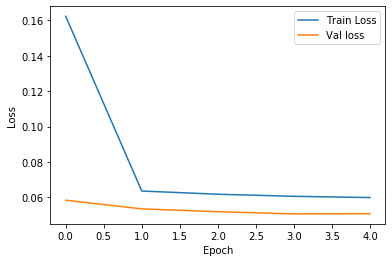

In [203]:
plot_history(history)

In [204]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.004
Validation Precision: 0.994
Validation Recall: 0.978


## SIO [201-300]

In [225]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/SIO/'
filenames = os.listdir(datapath)
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[201:300], 5)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    

500


In [226]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [227]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterSIO_v3.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterSIO_v2.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 167771 samples, validate on 41943 samples
Epoch 1/5
167771/167771 [==============================] - 2s 14us/step - loss: 0.1620 - precision_20: 0.8683 - recall_20: 0.6749 - val_loss: 0.1475 - val_precision_20: 0.8907 - val_recall_20: 0.7201
Epoch 2/5
167771/167771 [==============================] - 2s 9us/step - loss: 0.1213 - precision_20: 0.8948 - recall_20: 0.7337 - val_loss: 0.1114 - val_precision_20: 0.9029 - val_recall_20: 0.7426
Epoch 3/5
167771/167771 [==============================] - 2s 9us/step - loss: 0.1083 - precision_20: 0.9082 - recall_20: 0.7495 - val_loss: 0.0999 - val_precision_20: 0.9126 - val_recall_20: 0.7565
Epoch 4/5
167771/167771 [==============================] - 2s 9us/step - loss: 0.0983 - precision_20: 0.9159 - recall_20: 0.7628 - val_loss: 0.0897 - val_precision_20: 0.9192 - val_recall_20: 0.7675
Epoch 5/5
167771/167771 [==============================] - 2s 9us/step - loss: 0.0912 - precision_20: 0.9217 - recall_20: 0.7721 - val_loss: 0.0846 - va

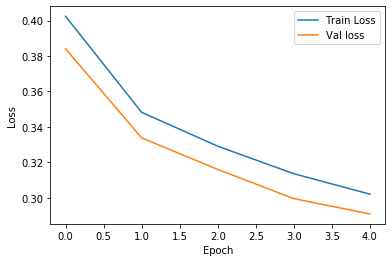

In [228]:
plot_history(history)

In [229]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.086
Validation Precision: 0.924
Validation Recall: 0.780


## SIO 301-400

In [239]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/SIO/'
filenames = os.listdir(datapath)
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[301:400], 5)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    

500


In [240]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [241]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterSIO_v4.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterSIO_v3.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 264940 samples, validate on 66236 samples
Epoch 1/5
264940/264940 [==============================] - 3s 12us/step - loss: 0.0412 - precision_21: 0.2703 - recall_21: 0.7720 - val_loss: 0.0110 - val_precision_21: 0.4357 - val_recall_21: 0.7444
Epoch 2/5
264940/264940 [==============================] - 2s 9us/step - loss: 0.0115 - precision_21: 0.5141 - recall_21: 0.7373 - val_loss: 0.0081 - val_precision_21: 0.5710 - val_recall_21: 0.7371
Epoch 3/5
264940/264940 [==============================] - 2s 9us/step - loss: 0.0095 - precision_21: 0.6108 - recall_21: 0.7350 - val_loss: 0.0073 - val_precision_21: 0.6430 - val_recall_21: 0.7347
Epoch 4/5
264940/264940 [==============================] - 2s 9us/step - loss: 0.0085 - precision_21: 0.6694 - recall_21: 0.7380 - val_loss: 0.0078 - val_precision_21: 0.6881 - val_recall_21: 0.7416
Epoch 5/5
264940/264940 [==============================] - 2s 9us/step - loss: 0.0077 - precision_21: 0.7045 - recall_21: 0.7468 - val_loss: 0.0061 - va

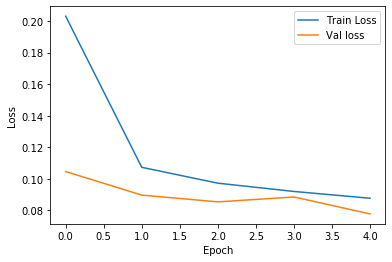

In [242]:
plot_history(history)

In [243]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.008
Validation Precision: 0.727
Validation Recall: 0.751


## SIO 401-500

In [262]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/SIO/'
filenames = os.listdir(datapath)
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[401:499], 4)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    

500


In [263]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [264]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterSIO_v5.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterSIO_v4.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 207180 samples, validate on 51796 samples
Epoch 1/5
207180/207180 [==============================] - 3s 13us/step - loss: 0.1247 - precision_22: 0.3673 - recall_22: 0.1637 - val_loss: 0.1015 - val_precision_22: 0.4311 - val_recall_22: 0.1235
Epoch 2/5
207180/207180 [==============================] - 2s 9us/step - loss: 0.0977 - precision_22: 0.4688 - recall_22: 0.1156 - val_loss: 0.0953 - val_precision_22: 0.4960 - val_recall_22: 0.1109
Epoch 3/5
207180/207180 [==============================] - 2s 9us/step - loss: 0.0937 - precision_22: 0.5210 - recall_22: 0.1110 - val_loss: 0.0925 - val_precision_22: 0.5446 - val_recall_22: 0.1109
Epoch 4/5
207180/207180 [==============================] - 2s 9us/step - loss: 0.0911 - precision_22: 0.5647 - recall_22: 0.1126 - val_loss: 0.0916 - val_precision_22: 0.5829 - val_recall_22: 0.1160
Epoch 5/5
207180/207180 [==============================] - 2s 9us/step - loss: 0.0888 - precision_22: 0.5981 - recall_22: 0.1200 - val_loss: 0.0903 - va

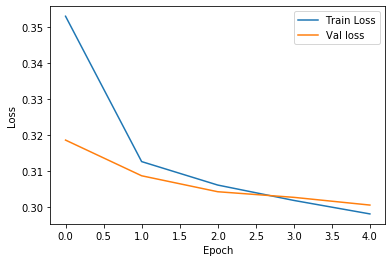

In [265]:
plot_history(history)

In [266]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.090
Validation Precision: 0.619
Validation Recall: 0.124


## now onto the US_multi data [0:100]

In [267]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/US_multi/'
filenames = os.listdir(datapath)
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[0:100], 25)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    

500


In [268]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [269]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterUS_multi_v1.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterSIO_v5.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 876218 samples, validate on 219055 samples
Epoch 1/5
876218/876218 [==============================] - 9s 10us/step - loss: 0.0578 - precision_23: 0.8238 - recall_23: 0.4648 - val_loss: 0.0411 - val_precision_23: 0.8469 - val_recall_23: 0.6124
Epoch 2/5
876218/876218 [==============================] - 8s 9us/step - loss: 0.0356 - precision_23: 0.8589 - recall_23: 0.6682 - val_loss: 0.0280 - val_precision_23: 0.8694 - val_recall_23: 0.7109
Epoch 3/5
876218/876218 [==============================] - 8s 9us/step - loss: 0.0277 - precision_23: 0.8785 - recall_23: 0.7393 - val_loss: 0.0222 - val_precision_23: 0.8872 - val_recall_23: 0.7632
Epoch 4/5
876218/876218 [==============================] - 8s 9us/step - loss: 0.0223 - precision_23: 0.8943 - recall_23: 0.7811 - val_loss: 0.0266 - val_precision_23: 0.8994 - val_recall_23: 0.7945
Epoch 5/5
876218/876218 [==============================] - 8s 9us/step - loss: 0.0188 - precision_23: 0.9035 - recall_23: 0.8050 - val_loss: 0.0147 - v

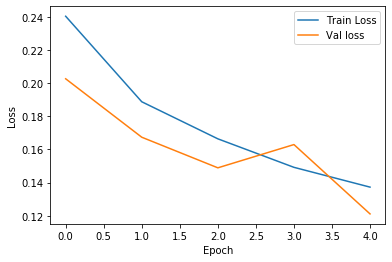

In [270]:
plot_history(history)

In [271]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.015
Validation Precision: 0.910
Validation Recall: 0.821


## US_multi [101-200]

In [272]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/US_multi/'
filenames = os.listdir(datapath)
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[101:200], 50)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    

500


In [273]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [274]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterUS_multi_v2.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterUS_multi_v1.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 1835614 samples, validate on 458904 samples
Epoch 1/5
1835614/1835614 [==============================] - 18s 10us/step - loss: 0.1074 - precision_24: 0.7970 - recall_24: 0.4562 - val_loss: 0.0702 - val_precision_24: 0.8451 - val_recall_24: 0.6339
Epoch 2/5
1835614/1835614 [==============================] - 17s 9us/step - loss: 0.0558 - precision_24: 0.8648 - recall_24: 0.6987 - val_loss: 0.0456 - val_precision_24: 0.8815 - val_recall_24: 0.7456
Epoch 3/5
1835614/1835614 [==============================] - 17s 9us/step - loss: 0.0425 - precision_24: 0.8920 - recall_24: 0.7741 - val_loss: 0.0387 - val_precision_24: 0.9027 - val_recall_24: 0.7940
Epoch 4/5
1835614/1835614 [==============================] - 17s 9us/step - loss: 0.0357 - precision_24: 0.9106 - recall_24: 0.8083 - val_loss: 0.0387 - val_precision_24: 0.9154 - val_recall_24: 0.8216
Epoch 5/5
1835614/1835614 [==============================] - 17s 9us/step - loss: 0.0320 - precision_24: 0.9189 - recall_24: 0.8316 - val_

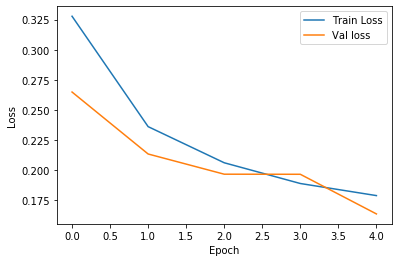

In [275]:
plot_history(history)

In [276]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.027
Validation Precision: 0.926
Validation Recall: 0.844


## US_multi [201-300]

In [279]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/US_multi/'
filenames = os.listdir(datapath)
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[201:300], 50)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    

500


In [280]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [281]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterUS_multi_v3.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterUS_multi_v2.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 1775730 samples, validate on 443933 samples
Epoch 1/5
1775730/1775730 [==============================] - 17s 10us/step - loss: 0.0345 - precision_25: 0.9301 - recall_25: 0.8860 - val_loss: 0.0206 - val_precision_25: 0.9477 - val_recall_25: 0.9200
Epoch 2/5
1775730/1775730 [==============================] - 16s 9us/step - loss: 0.0209 - precision_25: 0.9517 - recall_25: 0.9301 - val_loss: 0.0332 - val_precision_25: 0.9563 - val_recall_25: 0.9292
Epoch 3/5
1775730/1775730 [==============================] - 16s 9us/step - loss: 0.0180 - precision_25: 0.9595 - recall_25: 0.9288 - val_loss: 0.0155 - val_precision_25: 0.9616 - val_recall_25: 0.9335
Epoch 4/5
1775730/1775730 [==============================] - 16s 9us/step - loss: 0.0158 - precision_25: 0.9635 - recall_25: 0.9370 - val_loss: 0.0154 - val_precision_25: 0.9647 - val_recall_25: 0.9401
Epoch 5/5
1775730/1775730 [==============================] - 16s 9us/step - loss: 0.0142 - precision_25: 0.9657 - recall_25: 0.9424 - val_

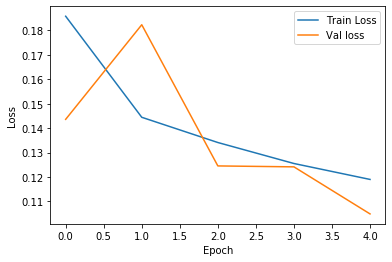

In [282]:
plot_history(history)

In [283]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.011
Validation Precision: 0.968
Validation Recall: 0.946


## US_multi [301-400]

In [284]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/US_multi/'
filenames = os.listdir(datapath)
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[301:400], 50)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    

500


In [285]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [286]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterUS_multi_v4.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterUS_multi_v3.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 1816547 samples, validate on 454137 samples
Epoch 1/5
1816547/1816547 [==============================] - 18s 10us/step - loss: 0.0298 - precision_26: 0.9384 - recall_26: 0.6220 - val_loss: 0.0190 - val_precision_26: 0.9539 - val_recall_26: 0.6979
Epoch 2/5
1816547/1816547 [==============================] - 17s 9us/step - loss: 0.0175 - precision_26: 0.9554 - recall_26: 0.7353 - val_loss: 0.0314 - val_precision_26: 0.9569 - val_recall_26: 0.7545
Epoch 3/5
1816547/1816547 [==============================] - 17s 9us/step - loss: 0.0152 - precision_26: 0.9578 - recall_26: 0.7656 - val_loss: 0.0138 - val_precision_26: 0.9590 - val_recall_26: 0.7802
Epoch 4/5
1816547/1816547 [==============================] - 17s 9us/step - loss: 0.0139 - precision_26: 0.9601 - recall_26: 0.7906 - val_loss: 0.0142 - val_precision_26: 0.9598 - val_recall_26: 0.8001
Epoch 5/5
1816547/1816547 [==============================] - 17s 9us/step - loss: 0.0131 - precision_26: 0.9594 - recall_26: 0.8075 - val_

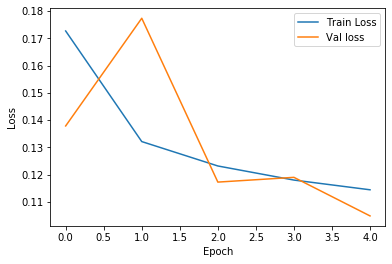

In [287]:
plot_history(history)

In [288]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.011
Validation Precision: 0.960
Validation Recall: 0.818


## FINAL ONE : US_multi [401-499]

In [289]:
# this should be the path of one region, e.g. data/JAMSTEC2/
# print(os.getcwd())

datapath = '/home/ubuntu/data/US_multi/'
filenames = os.listdir(datapath)
print(len(filenames))
data = []
count = 0.0

import random
from random import sample
sample = random.sample(filenames[401:499], 50)

for filename in sample:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()
    

500


In [290]:
# %%time
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [0, 1, 2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Hyper-parameters
epochs = 5         # This should be adjusted
batch_size = 256    # The larger the faster
learning_rate = 0.001

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [291]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weightsAfterUS_multi_FINALWEIGHTS.hdf5', verbose=0, save_best_only=True)
model.load_weights('weightsAfterUS_multi_v4.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])


Train on 1916664 samples, validate on 479166 samples
Epoch 1/5
1916664/1916664 [==============================] - 19s 10us/step - loss: 0.0118 - precision_27: 0.7762 - recall_27: 0.5944 - val_loss: 0.0096 - val_precision_27: 0.8306 - val_recall_27: 0.6288
Epoch 2/5
1916664/1916664 [==============================] - 18s 9us/step - loss: 0.0093 - precision_27: 0.8426 - recall_27: 0.6436 - val_loss: 0.0091 - val_precision_27: 0.8506 - val_recall_27: 0.6573
Epoch 3/5
1916664/1916664 [==============================] - 18s 9us/step - loss: 0.0084 - precision_27: 0.8552 - recall_27: 0.6670 - val_loss: 0.0075 - val_precision_27: 0.8625 - val_recall_27: 0.6732
Epoch 4/5
1916664/1916664 [==============================] - 18s 9us/step - loss: 0.0078 - precision_27: 0.8677 - recall_27: 0.6777 - val_loss: 0.0075 - val_precision_27: 0.8719 - val_recall_27: 0.6834
Epoch 5/5
1916664/1916664 [==============================] - 18s 9us/step - loss: 0.0073 - precision_27: 0.8748 - recall_27: 0.6884 - val_

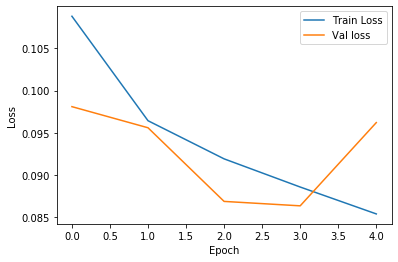

In [292]:
plot_history(history)

In [293]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.009
Validation Precision: 0.866
Validation Recall: 0.699
